In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import pandas as pd
import time
import batman
import emcee
import lightkurve as lk
import os
from multiprocessing import Process
import glob
import random as rd


In [4]:
2%2

0

In [5]:
flux = np.array([1,2,3,5,3,6,8,1])


np.argmax(flux >3)

3

In [6]:
12*60/30

24.0

In [7]:
import numba
from math import floor


@numba.jit(nopython=True)
def interpolation_search(x, z):
    n = len(x)
#     print(n)
    assert n > 1
    if z < x[1] or n == 2:
        return 0
    elif z >= x[-2]:
        return n - 2
    imin = 0
    imax = n - 1
    while imax - imin > 1:
        s = (z - x[imin]) / (x[imax] - x[imin])
        j = int(imin + floor((imax - imin) * s))
        if z >= x[j + 1]:
            imin = j + 1
        elif z < x[j]:
            imax = j
        else:
            return j
    return imin


@numba.jit(nopython=True)
def lerp(y, theta):
    return (1 - theta) * y[..., 0] + theta * y[..., 1]


class interp1d(object):
    """
    Adapted from:
    Fast multithreaded linear interpolation, 1D and 2D - Ver. 3.4
    This versione: 15/06/2018
    @author: Marco Maffezzoli, Universita Bocconi
    http://didattica.unibocconi.it/mypage/upload/49183_20180615_035144_INTERPOLATION.PY
    """

    def __init__(self, x_new, x):
        (self._index, self._theta) = self._locate(x_new, x)
        
    @staticmethod
    @numba.guvectorize("(i8[:],f8[:],f8[:],f8[:])", "(m),(m),(n)->(m)")
    def _linear(index, theta, y, y_new):
        for (j, (i, t)) in enumerate(zip(index, theta)):
            y_new[j] = lerp(y[i : i + 2], t)

    def __call__(self, y):
        return self._linear(self._index, self._theta, y)

    @numba.guvectorize("(f8[:],f8[:],i8[:],f8[:])", "(),(n)->(),()")
    def _locate(x_new, x, index, theta =[]):
        index[0] = i = interpolation_search(x, x_new[0])
        theta[0] = (x_new[0] - x[i]) / (x[i + 1] - x[i])

In [26]:
def reference_transit(per, rp, a, inc, ecc, w, u, limb_dark, samples = int(12*60/30)):
    """Returns an Earth-like transit of width 1 and depth 1"""
    ###Samples = maxwidth of samples = number of points in max duration val
    ###NOTE: TLS requires that his number be EVEN
    f = np.ones(1000)
    duration = 1  # transit duration in days. Increase for exotic cases. ###I want the max trans dur to be 12 hrs
    t = np.linspace(-duration * 0.5, duration * 0.5, 1000)
    t_2_lin = np.linspace(0., duration, 1000)
    ###FOR ME: T=time in lc <- NOT TRUE. WHY: this is a model. I would like each transit 
    ###to start at 0 and then go to x duration BECAUSE ising t0 = 0 is EASY and then i
    ###will SHIFT IT so the transit starts at 0 and t0 is size of shift 
    b_model           = batman.TransitParams()
    b_model.t0        = 0  # time of inferior conjunction
    b_model.per       = per  # orbital period, use Earth as a reference
    b_model.rp        = rp  # planet radius (in units of stellar radii)
    b_model.a         = a  # semi-major axis (in units of stellar radii)
    b_model.inc       = inc  # orbital inclination (in degrees)
    b_model.ecc       = ecc  # eccentricity
    b_model.w         = w  # longitude of periastron (in degrees)
    b_model.u         = u  # limb darkening coefficients
    b_model.limb_dark = limb_dark  # limb darkening model
    m = batman.TransitModel(b_model, t)  # initializes model
    model_flux = m.light_curve(b_model)  # calculates light curve

    # Determine start of transit (first value < 1)
    idx_first = np.argmax(model_flux < 1)
#     print(idx_first, len(model_flux))
    intransit_model_flux = model_flux[idx_first : -idx_first + 1]
    intransit_time = t[idx_first : -idx_first + 1] 

    # Downsample (bin) to target sample size
    x_new = np.linspace(t[idx_first], t[-idx_first - 1], samples)
#     print(type(x_new),type(x_new[0]), type(intransit_time), type(intransit_time[0]))

    f = interp1d(x_new, intransit_time)
#     print(type(intransit_model_flux), type(intransit_model_flux[0]))
    downsampled_intransit_model_flux = f(intransit_model_flux)

    # Rescale to height [0..1]
    rescaled = (np.min(downsampled_intransit_model_flux) - downsampled_intransit_model_flux) / (
        np.min(downsampled_intransit_model_flux) - 1
    )
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(111)
    ax.tick_params(axis='x', colors='None', labelsize = 35, width=3, length = 8)    #setting up X-axis tick color to red
    ax.tick_params(axis='y', colors='None', labelsize = 35, width=3, length = 8)  #setting up Y-axis tick color to black
    ax.spines['top'].set_color(None)        # setting up Y-axis tick color to red
    ax.spines['right'].set_color(None)         #setting up above X-axis tick color to red

    ax.spines['left'].set_color(None)        # setting up Y-axis tick color to red
    ax.spines['bottom'].set_color(None)         #setting up above X-axis tick color to red

    ax.set_facecolor('None')
    ax.xaxis.label.set_color('None')        #setting up X-axis label color to yellow
    ax.yaxis.label.set_color('None')          #setting up Y-axis label color to blue


    ax.plot(np.linspace(min(intransit_time), max(intransit_time), len(rescaled)), rescaled, color = '#FFD475', lw = 10)
    plt.show()
    return rescaled #, intransit_time

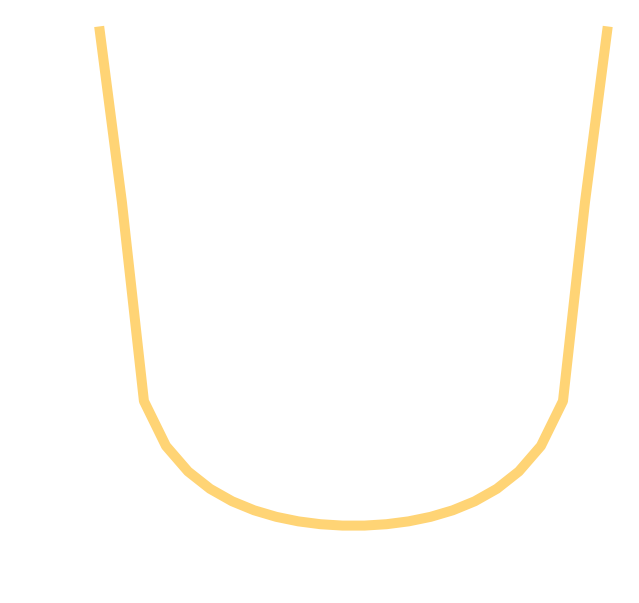

In [19]:
a = reference_transit(20., 0.1, 0.15*215., 90., 0., 180., [0.3, 0.2], 'quadratic', samples = int(12*60/30))






In [20]:
plt.plot(np.linspace(min(t), max(t), len(a)), a)

NameError: name 't' is not defined

In [21]:
12*60 

720

In [22]:
durations = np.linspace(1, 12, 23)*60
durations

array([ 60.,  90., 120., 150., 180., 210., 240., 270., 300., 330., 360.,
       390., 420., 450., 480., 510., 540., 570., 600., 630., 660., 690.,
       720.])

In [37]:

def fractional_transit(
    duration,
    maxwidth,
    depth,
    samples,
    per,
    rp,
    a,
    inc,
    ecc,
    w,
    u,
    limb_dark,
    cached_reference_transit=None,
):
    """Returns a scaled reference transit with fractional width and depth"""

    if cached_reference_transit is None:
#         print('a')
        reference_flux = reference_transit(
            samples=samples,
            per=per,
            rp=rp,
            a=a,
            inc=inc,
            ecc=ecc,
            w=w,
            u=u,
            limb_dark=limb_dark,
        )
    else:
#         print('b')
        reference_flux = cached_reference_transit

    # Interpolate to shorter interval - new method without scipy
    reference_time = np.linspace(-0.5, 0.5, samples)
    occupied_samples = int((duration / maxwidth) * samples)
    x_new = np.linspace(-0.5, 0.5, occupied_samples)
#     print(type(x_new),type(x_new[0]), type(reference_time), type(reference_time[0]))
    f = interp1d(x_new, reference_time)
#     print(type(reference_flux), type(reference_flux[0]))
    y_new = f(reference_flux)

    # Patch ends with ones ("1")
    missing_samples = samples - occupied_samples
    emtpy_segment = np.ones(int(missing_samples * 0.5))
    result = np.append(emtpy_segment, y_new)
    result = np.append(result, emtpy_segment)
#     print(len(result), len(reference_time))
    if np.size(result) < samples:  # If odd number of samples
        result = np.append(result, np.ones(1))

    # Depth rescaling
    result = 1 - ((1 - result) * depth)
#     print(duration)
    fig = plt.figure(figsize = (10,7))
    ax = fig.add_subplot(111)
    ax.tick_params(axis='x', colors='None', labelsize = 35, width=3, length = 8)    #setting up X-axis tick color to red
    ax.tick_params(axis='y', colors='None', labelsize = 35, width=3, length = 8)  #setting up Y-axis tick color to black
    ax.spines['top'].set_color(None)        # setting up Y-axis tick color to red
    ax.spines['right'].set_color(None)         #setting up above X-axis tick color to red

    ax.spines['left'].set_color(None)        # setting up Y-axis tick color to red
    ax.spines['bottom'].set_color(None)         #setting up above X-axis tick color to red

    ax.set_facecolor('None')
    ax.xaxis.label.set_color('None')        #setting up X-axis label color to yellow
    ax.yaxis.label.set_color('None')          #setting up Y-axis label color to blue


    ax.plot(np.linspace(min(reference_time), max(reference_time), len(result)), result, color = '#FFD475', lw = 10)

    plt.show()

    return result

In [38]:
def get_cache(durations, rp = 0.03, per=20., a =0.15*215., inc=89.5, ecc=0., w=180., u=[0.2, 0.1],
              limb_dark='quadratic', verbose=True, maxwidth_in_samples = int(12*60/30)):
    """Fetches (size(durations)*size(depths)) light curves of length 
        maxwidth_in_samples and returns these LCs in a 2D array, together with 
        their metadata in a separate array."""

    if verbose:
        print("Creating model cache for", str(len(durations)), "durations")
    lc_arr = []
    rows = np.size(durations)
    lc_cache_overview = np.zeros(
        rows,
        dtype=[("duration", "float128"), ("width_in_samples", "int64"), ("overshoot", "float128")],
    )
    cached_reference_transit = reference_transit(
#         samples=maxwidth_in_samples,
        per=per,
        rp=rp,
        a=a,
        inc=inc,
        ecc=ecc,
        w=w,
        u=u,
        limb_dark=limb_dark,
    )

    row = 0
    for duration in durations:
        scaled_transit = fractional_transit(
            duration=duration,
            maxwidth=np.max(durations),
            depth=0.5,
            samples=maxwidth_in_samples,
            per=per,
            rp=rp,
            a=a,
            inc=inc,
            ecc=ecc,
            w=w,
            u=u,
            limb_dark=limb_dark,
            cached_reference_transit=cached_reference_transit,
        )
        lc_cache_overview["duration"][row] = duration
        used_samples = int((duration / np.max(durations)) * maxwidth_in_samples)
        lc_cache_overview["width_in_samples"][row] = used_samples
        full_values = np.where(
            scaled_transit < (1 - 0.01 * 10 ** -6 )
        )
#         print(scaled_transit < (1 - 0.01 * 10 ** -6 ))
        first_sample = np.min(full_values)
        last_sample = np.max(full_values) + 1
        signal = scaled_transit[first_sample:last_sample]
        lc_arr.append(signal)

        # Fraction of transit bottom and mean flux
        overshoot = np.mean(signal) / np.min(signal)
        # Later, we multiply the inverse fraction ==> convert to inverse percentage
        lc_cache_overview["overshoot"][row] = 1 / (2 - overshoot)
#         print(overshoot, 1 / (2 - overshoot))
        row += +1
        

    lc_arr = np.array(lc_arr, dtype=object)
    return lc_cache_overview, lc_arr


Creating model cache for 23 durations


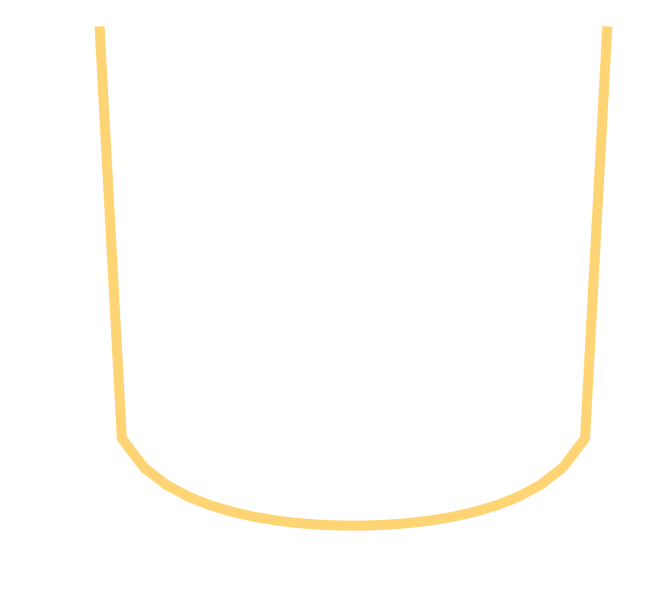

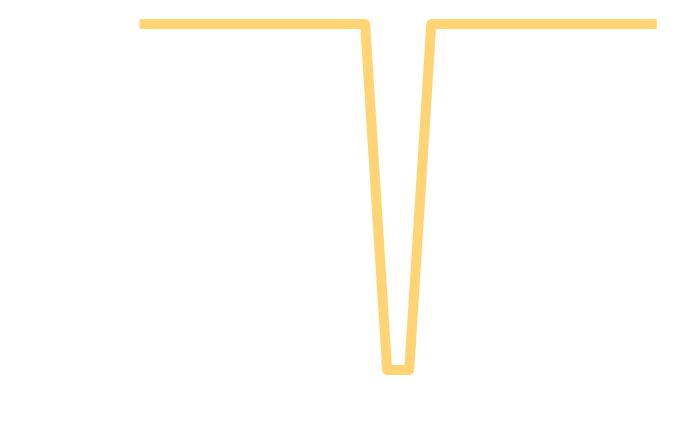

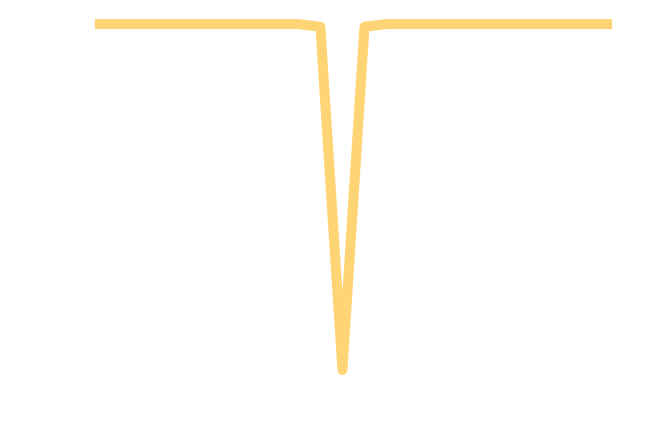

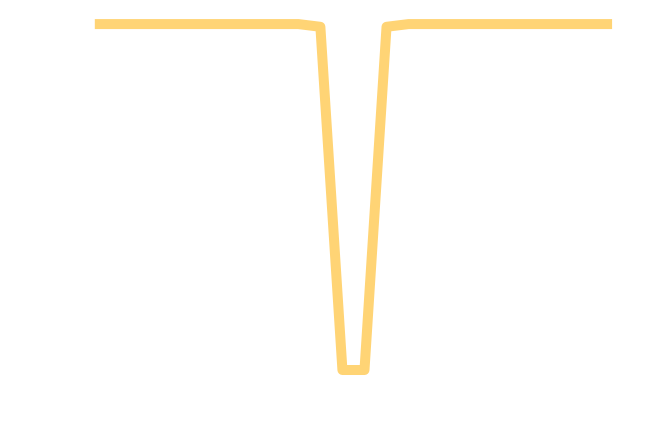

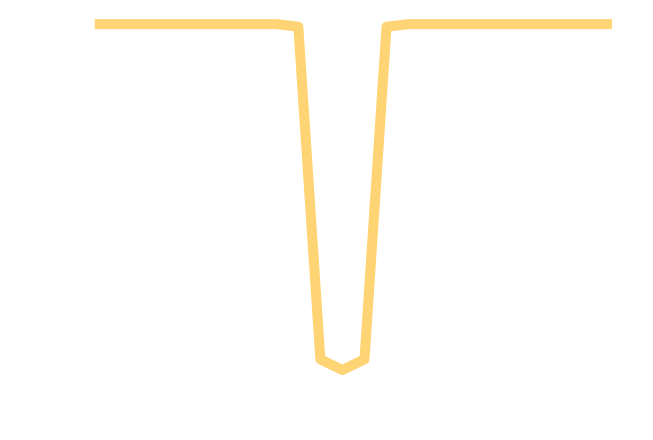

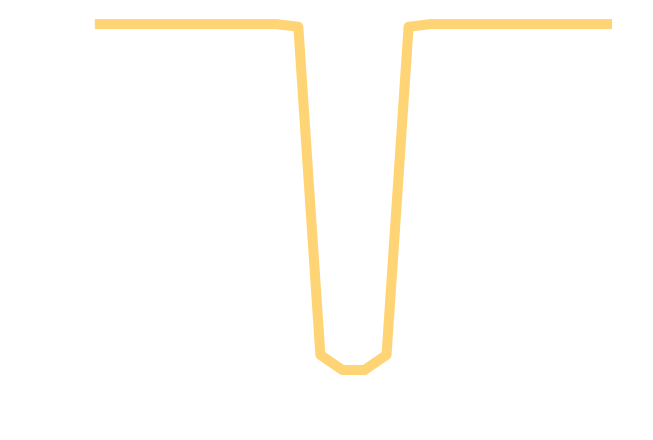

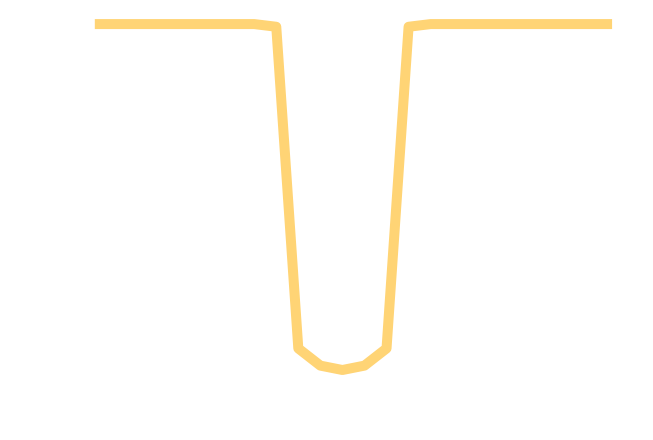

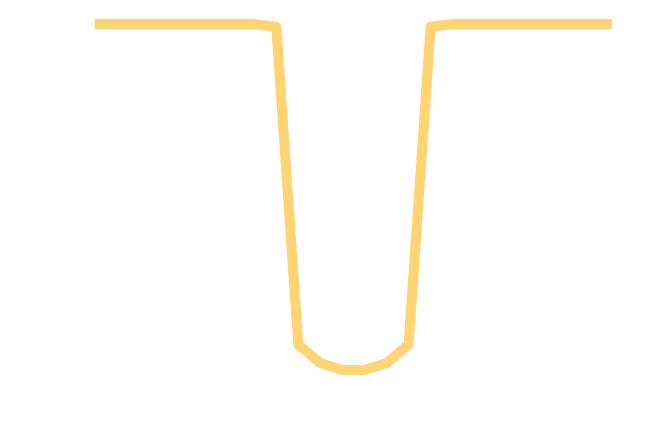

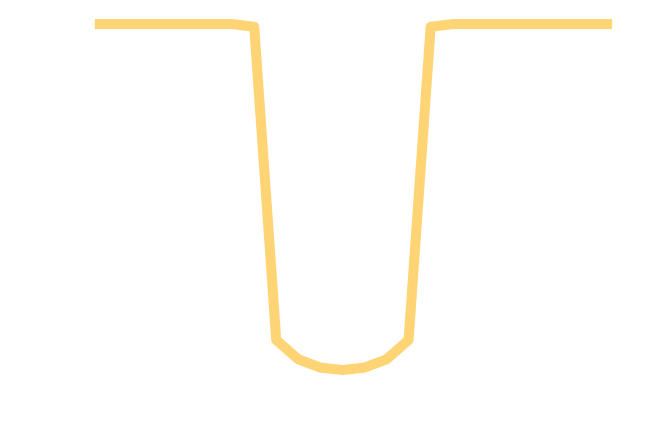

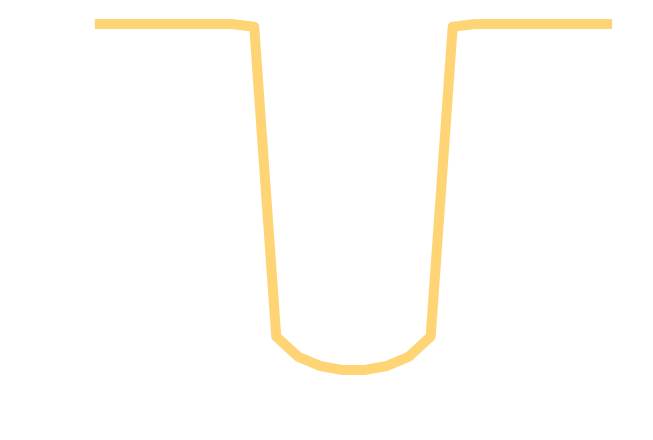

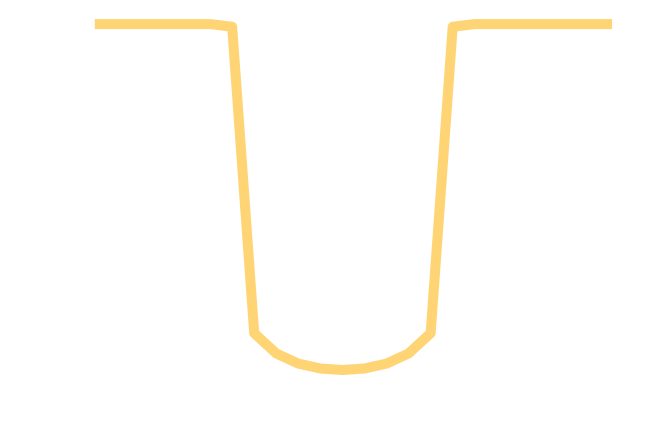

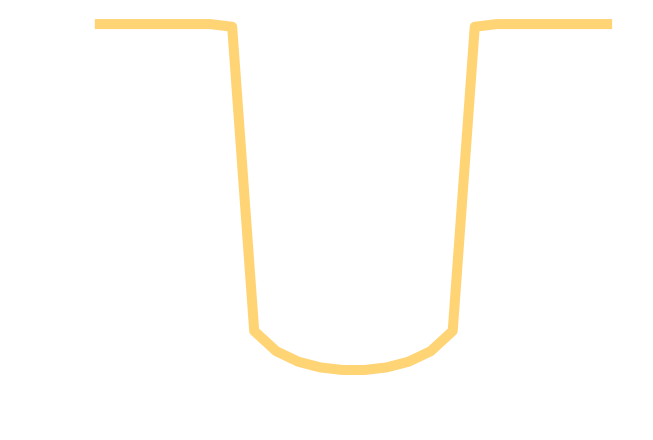

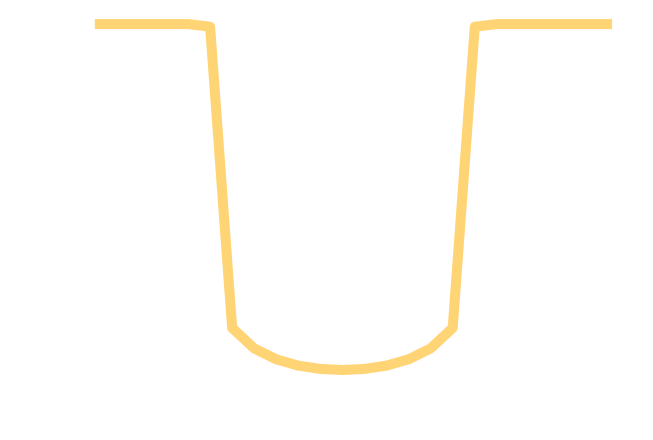

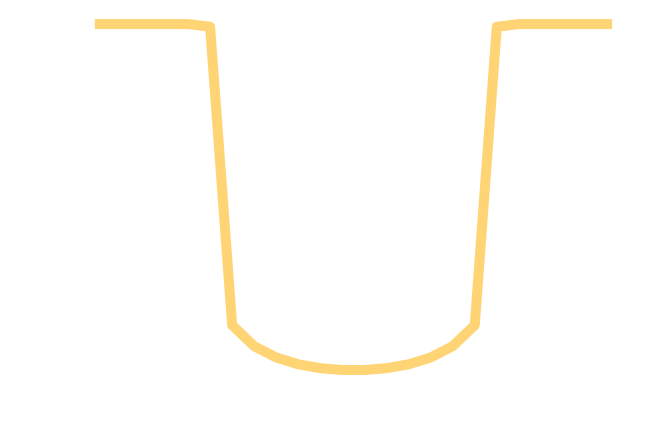

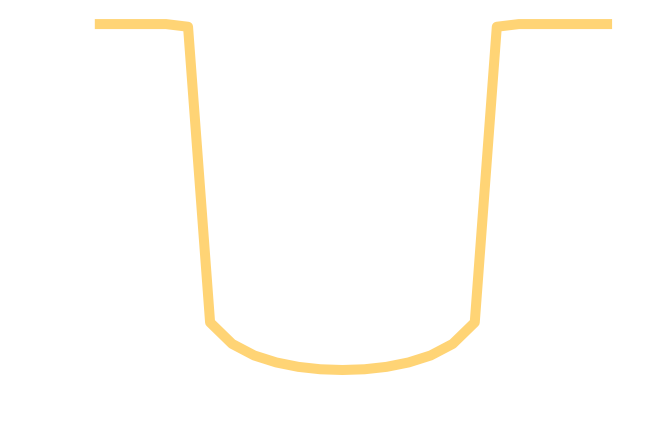

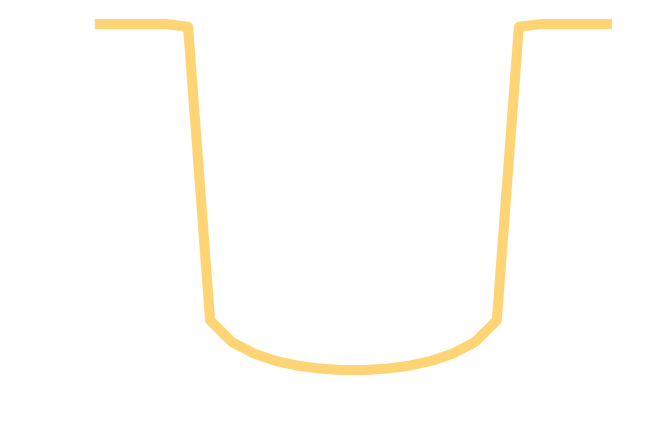

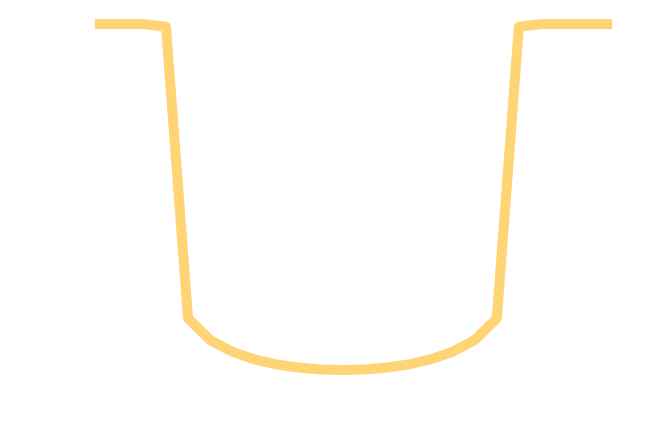

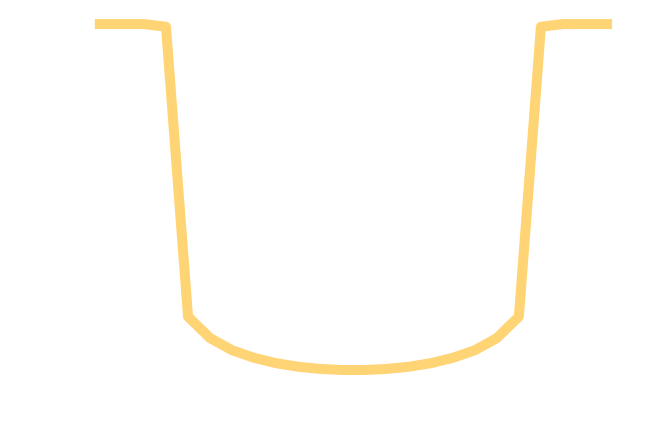

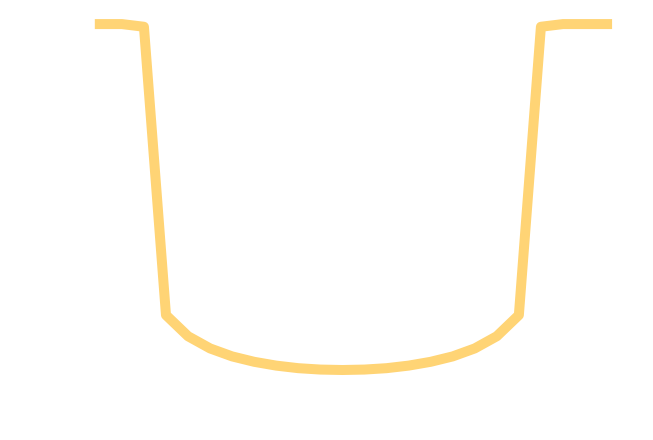

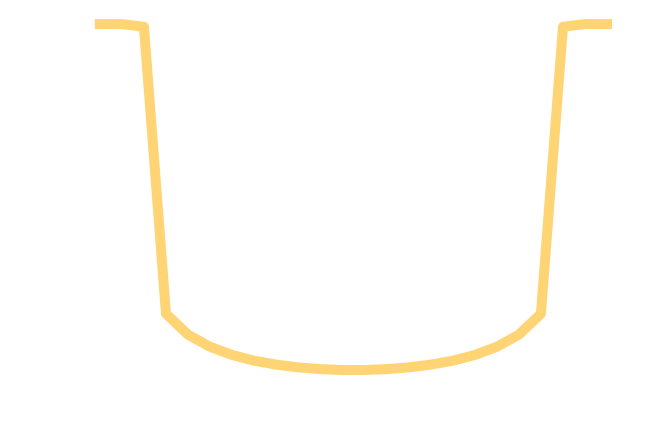

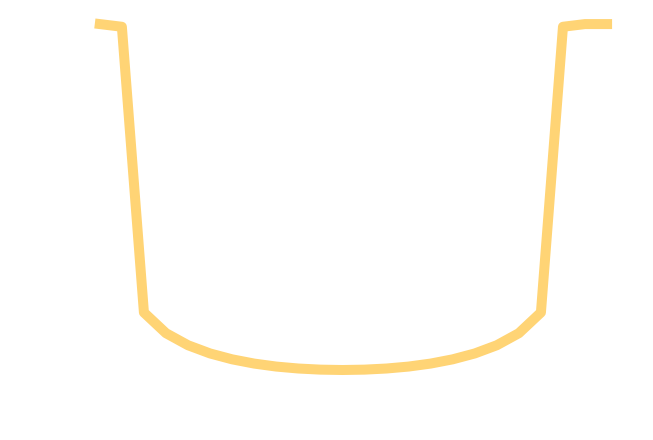

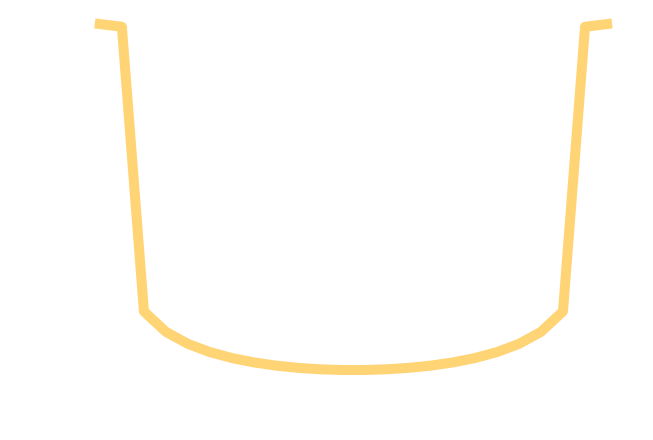

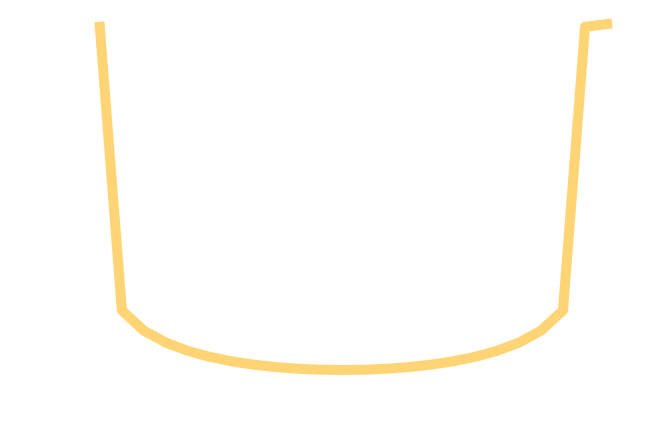

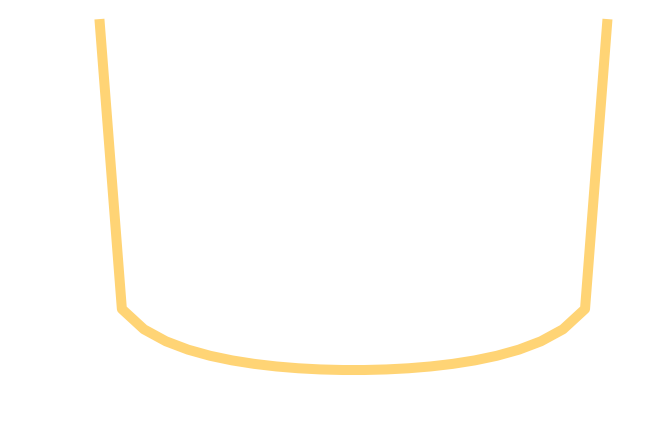

In [39]:
b, c = get_cache(durations)

In [258]:
len(b)
strings = [str(a[1]) for a in b]
len(set(strings))




23

In [259]:
b['width_in_samples'][2]

4

In [260]:
width_signal = 2
data = [1,2,3,4,5,6,7,8,9]
data[:width_signal]
data

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [261]:
@numba.jit(fastmath=True, parallel=False, nopython=True)
def out_of_transit_residuals(data, width_signal, inv_sq_dy):
    chi2 = numpy.zeros(len(data) - width_signal + 1)
    fullsum = numpy.sum(((1 - data) ** 2) * inv_sq_dy)
    window = numpy.sum(((1 - data[:width_signal]) ** 2) * inv_sq_dy[:width_signal])
    chi2[0] = fullsum - window
    for i in range(1, len(data) - width_signal + 1):
        becomes_visible = i - 1
        becomes_invisible = i - 1 + width_signal
        add_visible_left = (1 - data[becomes_visible]) ** 2 * inv_sq_dy[becomes_visible]
        remove_invisible_right = (1 - data[becomes_invisible]) ** 2 * inv_sq_dy[
            becomes_invisible
        ]
        chi2[i] = chi2[i - 1] + add_visible_left - remove_invisible_right
    return chi2


In [277]:
array = np.array([1,2,3,4,5,6])*10
small_arr1 = array[1:3]
small_arr1
np.delete(array, range(1,3))
small_arr1


array([20, 30])

In [231]:

@numba.jit(fastmath=True, parallel=False, nopython=True)
def lowest_residuals_in_this_duration(
    mean,
    #This will come from my snr grid
    transit_depth_min,
    data_arr,
    duration,
    signal,
    inverse_squared_dy_arr,
    overshoot,
    ootr,
    summed_edge_effect_correction,
    chosen_transit_row,
    datapoints,
    T0_fit_margin, threshold = 7.3
):
    SNR = 0.
    start_T0 = []
    residuals = np.full(len(mean), np.nan, dtype=[('chi2','float128')])
    # if nothing is fit, we fit a straight line: signal=1. Then, at dy=1,
    # the squared sum of residuals equals the number of datapoints
    summed_residual_in_rows = datapoints
    best_row = 0
    best_depth = 0

    xth_point = 1  # How many cadences the template shifts forward in each step
    if T0_fit_margin > 0 and duration > T0_fit_margin:
        T0_fit_margin = 1 / T0_fit_margin
        xth_point = int(duration / T0_fit_margin)
        if xth_point < 1:
            xth_point = 1

    for i in range(len(mean)):
        if (mean[i] > transit_depth_min) and (i % xth_point == 0):
            data = data_arr[i : i + duration]
            flux_oot = np.delete(data_arr, range(i,i+duration))

            dy = inverse_squared_dy_arr[i : i + duration]
            target_depth = mean[i] * overshoot
            scale = tls_constants.SIGNAL_DEPTH / target_depth
            reverse_scale = 1 / scale  # speed: one division now, many mults later
            snr = (mean[i] / (np.std(flux_oot)*np.sqrt(0.5))) * duration ** (0.5)
#             if snr<threshold:
#                 continue
            # Scale model and calculate residuals
#             SNR+=snr
            intransit_residual = 0
            for j in range(len(signal)):
                sigi = (1 - signal[j]) * reverse_scale
                intransit_residual += ((data[j] - (1 - sigi)) ** 2) * dy[j]
            current_stat = intransit_residual + ootr[i] #- summed_edge_effect_correction
            residuals.append(current_stat)
            if current_stat < summed_residual_in_rows:
                summed_residual_in_rows = current_stat
                best_row = chosen_transit_row
                best_depth = 1 - target_depth
    return summed_residual_in_rows, best_row, best_depth, SNR, T0, residuals

In [ ]:
snr = ((1 - depth_mean) / np.std(flux_ootr)) * len( all_flux_intransit) ** (0.5)

In [232]:
c[30]

array([0.99737994, 0.90711118, 0.9020853 , 0.90020223, 0.90020223,
       0.9020853 , 0.90711118, 0.99737994])

In [233]:
len(c[30])

8

In [350]:
1-c[13]

array([0.00388735, 0.43121357, 0.46225172, 0.47897943, 0.48907284,
       0.49545752, 0.49894387, 0.5       , 0.49894387, 0.49545752,
       0.48907284, 0.47897943, 0.46225172, 0.43121357, 0.00388735])

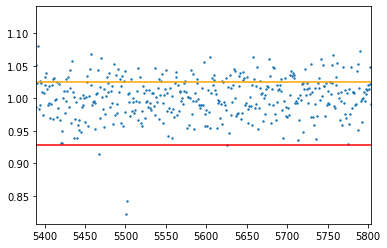

4.746067643198914 1.5664936598028778 9.606644350079621


In [573]:
array = np.random.normal(1, 0.03, 32000)
array[5500:5500+len(c[2])] = 1-(0.4*(1-c[2]))+np.random.normal(0, 0.03, len(c[2]))



intransit = array[5500:5500+len(c[2])]

1-running_mean(array, len(intransit))

plt.scatter(range(len(array)), array, s = 2)
plt.plot([0, len(running_mean(array, len(intransit)))], np.full(2, np.mean(intransit)), color = 'red')
plt.plot([0, len(running_mean(array, len(intransit)))], np.full(2, np.std(intransit)+np.mean(intransit)), color = 'orange')
plt.xlim([5390, 5500+len(intransit)+300])
plt.show()

oot = np.delete(array, range(5500, 5500+len(intransit)))
np.std(oot)

mean  = running_mean(data=array, window_size=2)
cdpp = np.std(mean) 


snr_tls = ((1 - np.mean(intransit)) / np.std(oot)) * len( intransit) ** (0.5)
snr_vil = (1 -np.mean(intransit)) / cdpp * np.abs(np.min(intransit)-np.max(intransit))**(0.5)
snr_sul = (np.mean(intransit))/np.std(intransit)
print(snr_tls, snr_vil, snr_sul)



In [536]:
def running_mean(data, window_size):
    """Returns the moving average of an array `data`.
    Parameters
    ----------
    data : array of numbers
        The running mean will be computed on this data.
    window_size : int
        Window length used to compute the running mean.
    """
    cumsum = np.cumsum(np.insert(data, 0, 0))
    return (cumsum[window_size:] - cumsum[:-window_size]) / float(window_size)


In [395]:
new_array = np.full(
        len(range(1,24)), fill_value = 0,
        dtype=[("duration_pts", "float128"), ("residuals", "int64"), ('T0_times', 'object')],
    )
for i in range(len(new_array)):
    new_array[i][2]=[]


array([(0., 0, list([2])), (0., 0, list([])), (0., 0, list([])),
       (0., 0, list([])), (0., 0, list([])), (0., 0, list([])),
       (0., 0, list([])), (0., 0, list([])), (0., 0, list([])),
       (0., 0, list([])), (0., 0, list([])), (0., 0, list([])),
       (0., 0, list([])), (0., 0, list([])), (0., 0, list([])),
       (0., 0, list([])), (0., 0, list([])), (0., 0, list([])),
       (0., 0, list([])), (0., 0, list([])), (0., 0, list([])),
       (0., 0, list([])), (0., 0, list([]))],
      dtype=[('duration_pts', '<f16'), ('residuals', '<i8'), ('T0_times', 'O')])

In [236]:
def search_best_fit_duration(
#     duration,
    t,
    y,
    dy,
    transit_depth_min,
#     R_star_min,
#     R_star_max,
#     M_star_min,
#     M_star_max,
    lc_arr,
    lc_cache_overview,
    T0_fit_margin,
):
    """Core routine to search the flux data set 'injected' over all 'periods'"""
    SNR_val = 0.
    # duration (in samples) of widest transit in lc_cache (axis 0: rows; axis 1: columns)
    npoints_in_duration = np.unique(lc_cache_overview["width_in_samples"])
    residuals_grid = np.zeros(
        len(npoints_in_duration),
        dtype=[("duration_pts", "float128"), ("residuals", "int64"), ''],
    )

    maxwidth_in_samples = int(max(npoints_in_duration))
    if maxwidth_in_samples % 2 != 0:
        maxwidth_in_samples = maxwidth_in_samples + 1

#     # Phase fold
#     phases = foldfast(t, period)
#     sort_index = np.argsort(phases, kind="mergesort")  # 8% faster than Quicksort
#     phases = phases[sort_index]
#     flux = y[sort_index]
#     dy = dy[sort_index]

#     # faster to multiply than divide
#     patched_dy = np.append(dy, dy[:maxwidth_in_samples])


### prending that this is running over each point in time series:
### WILL ALSO NEED TO THINK ABOUT GAPS IN DATA - IF GAP>3hrs, just skip
### MAYBE JUST DIVIDE DATA INTO B4 and AFTER GAP, AND TREAT BOTH THE SAME

###THIS CODE AT THE BEGINNING IS WRONG. THE maxwidth_in_samples needs to be an upperlimit, but should differ
###duration to durationkk
###    if np.where(t==search_time)>=3 and np.where(t==search_time)<window_gap+3:
###             window_indexes = [3:i+maxwidth_in_samples+window_gap]
###    elif np.where(t==search_time)>=window_gap and np.where(t==search_time)<len(t)-maxwidth_in_samples-2*window_gap-3:
###             window_indexes = [i:i+maxwidth_in_samples+2*window_gap]


###THIS LAST ONE IS HARDER: IT SHOULD DEPEND ON THE DURATION LENGTH
###    elif np.where(t==search_time)<=len(t)-window_gap and np.where(t==search_time)<len(t)-3:
###             window_indexes = [i-window_gap:i+maxwidth_in_samples+window_gap]
###    data_window = maxwidth
    
    inverse_squared_dy = 1 / dy ** 2

#     # Due to phase folding, the signal could start near the end of the data
#     # and continue at the beginning. To avoid (slow) rolling,
#     # we patch the beginning again to the end of the data
#     patched_data = np.append(flux, flux[:maxwidth_in_samples])

#     this_edge_effect_correction = edge_effect_correction(
#         flux, patched_data, dy, inverse_squared_patched_dy
#     )

    # Set "best of" counters to max, in order to find smaller residuals
#     smallest_residuals_in_period = float("inf")
    summed_residual_in_rows = float("inf")

    # Make unique to avoid duplicates in dense grids
#     duration_max = max(npoints_in_duration)
#     duration_min = min(npoints_in_duration)

    # Fractional transit duration can be longer than this.
    # Example: Data length 11 days, 2 transits at 0.5 days and 10.5 days
#     length = max(t) - min(t)
#     no_of_transits_naive = length / period
#     no_of_transits_worst = no_of_transits_naive + 1
#     correction_factor = no_of_transits_worst / no_of_transits_naive

#     duration_min_in_samples = int(np.floor(duration_min * len(y)))
#     duration_max_in_samples = int(np.ceil(duration_max * len(y) * correction_factor))
    
    ###THESE DURATIONS WILL BE SET, BUT USING DIFFERENT CRITERIA THAN THEY DO
    ###DUR(SNR>7.3)
    ###DUR<(t_final-t_transit_begin)
#     npoints_in_duration = npoints_in_duration[npoints_in_duration >= duration_min_in_samples]
#     npoints_in_duration = npoints_in_duration[npoints_in_duration <= duration_max_in_samples]

    skipped_all = True
    best_row = 0  # shortest and shallowest transit
    best_depth = 0


    for dur in npoints_in_duration:
        chosen_transit_row = 0
        while lc_cache_overview["width_in_samples"][chosen_transit_row] != dur:
            chosen_transit_row += 1
            this_residual, this_row, this_depth, snr = lowest_residuals_in_this_duration(
            mean=1 - running_mean(y, dur),
            transit_depth_min=transit_depth_min,
            patched_data_arr=y,
            duration=dur,
            signal=lc_arr[chosen_transit_row],
            inverse_squared_dy_arr=inverse_squared_dy,
            overshoot=lc_cache_overview["overshoot"][chosen_transit_row],
            ootr=out_of_transit_residuals(
                y, dur, inverse_squared_dy
            ),
            summed_edge_effect_correction=this_edge_effect_correction,
            chosen_transit_row=chosen_transit_row,
            datapoints=len(y),
            T0_fit_margin=T0_fit_margin,
        )
            SNR_val+=snr
        if this_residual < summed_residual_in_rows:
            summed_residual_in_rows = this_residual
            best_row = chosen_transit_row
            best_depth = this_depth

    return [period, summed_residual_in_rows, best_row, best_depth]

In [237]:

def rp_rs_from_depth(depth, law, params):
    """Takes the maximum transit depth, limb-darkening law and parameters
    Returns R_P / R_S (ratio of planetary to stellar radius)
    Source: Heller 2019, https://arxiv.org/abs/1901.01730"""

    # Validations:
    # - LD law must exist
    # - All parameters must be floats or ints
    # - All parameters must be given in the correct quanitity for the law

    if len(params) == 1:
        params = float(params[0])

    if not isinstance(params, (float, int)) and not all(
        isinstance(x, (float, int)) for x in params
    ):
        raise ValueError("All limb-darkening parameters must be numbers")

    laws = "linear, quadratic, squareroot, logarithmic, nonlinear"
    if law not in laws:
        raise ValueError("Please provide a supported limb-darkening law:", laws)

    if law == "linear" and not isinstance(params, float):
        raise ValueError("Please provide exactly one parameter")

    if law in "quadratic, logarithmic, squareroot" and len(params) != 2:
        raise ValueError("Please provide exactly two limb-darkening parameters")

    if law == "nonlinear" and len(params) != 4:
        raise ValueError("Please provide exactly four limb-darkening parameters")

    # Actual calculations of the return value
    if law == "linear":
        return (depth * (1 - params / 3)) ** (1 / 2)

    if law == "quadratic":
        return (depth * (1 - params[0] / 3 - params[1] / 6)) ** (1 / 2)

    if law == "squareroot":
        return (depth * (1 - params[0] / 3 - params[1] / 5)) ** (1 / 2)

    if law == "logarithmic":
        return (depth * (1 + 2 * params[1] / 9 - params[0] / 3)) ** (1 / 2)

    if law == "nonlinear":
        return (
            depth
            * (1 - params[0] / 5 - params[1] / 3 - 3 * params[2] / 7 - params[3] / 2)
        ) ** (1 / 2)


In [238]:
depth_mean = np.mean(all_flux_intransit)
snr = ((1 - depth_mean) / np.std(flux_ootr)) * len( all_flux_intransit) ** (0.5)

NameError: name 'numpy' is not defined

In [ ]:
###THIS COMES FROM THE FUNCTION SPECTRA (MOSTLY)

chi2 = test_statistic_residuals

SR = np.min(chi2) / chi2
SDE_raw = (1 - np.mean(SR)) / np.std(SR)

# Scale SDE_power from 0 to SDE_raw
power_raw = SR - np.mean(SR)  # shift down to the mean being zero
scale = SDE_raw / np.max(power_raw)  # scale factor to touch max=SDE_raw
power_raw = power_raw * scale
index_highest_power = np.argmax(power_raw)
depth = test_statistic_depths[index_highest_power]
trials = 0
while trials<10:
    if depth<min_rp:
        np.delete(power_raw, index_highest_power)


In [239]:
def recursive_function_finding_good_fit_planets(power_raw, test_statistic_depths, min_rp_depth, trials = 0):
    while trials<10:
        index_highest_power = np.argmax(power_raw)
        depth = test_statistic_depths[index_highest_power]
        if depth<min_rp_depth:
            np.delete(power_raw, index_highest_power)
            recursive_function_finding_good_fit_planets(power_raw, test_statistic_depths, min_rp_depth, trials = trials+1)
        else:
            return depth
    if trials>=10:
        print("Too shallow a signal to be a discoverable planet")
        return None

In [ ]:
def final_T0_fit(signal, depth, t, y, dy, period, T0_fit_margin, show_progress_bar, verbose):
    """ After the search, we know the best period, width and duration.
        But T0 was not preserved due to speed optimizations. 
        Thus, iterate over T0s using the given parameters
        Fold to all T0s so that the transit is expected at phase = 0"""

    dur = len(signal)
    scale = tls_constants.SIGNAL_DEPTH / (1 - depth)
    signal = 1 - ((1 - signal) / scale)
    samples_per_period = numpy.size(y)

    if T0_fit_margin == 0:
        points = samples_per_period
    else:
        step_factor = T0_fit_margin * dur
        points = int(samples_per_period / step_factor)
    if points > samples_per_period:
        points = samples_per_period

    # Create all possible T0s from the start of [t] to [t+period] in [samples] steps
    T0_array = numpy.linspace(
        start=numpy.min(t), stop=numpy.min(t) + period, num=points
    )

    # Avoid showing progress bar when expected runtime is short
    if points > tls_constants.PROGRESSBAR_THRESHOLD and show_progress_bar:
        show_progress_info = True
    else:
        show_progress_info = False

    residuals_lowest = float("inf")
    T0 = 0

    if verbose:
        print("Searching for best T0 for period", format(period, ".5f"), "days")

    if show_progress_info:
        pbar2 = tqdm(total=numpy.size(T0_array))
    signal_ootr = numpy.ones(len(y[dur:]))

    # Future speed improvement possible: Add multiprocessing. Will be slower for
    # short data and T0_FIT_MARGIN > 0.01, but faster for large data with dense
    # sampling (T0_FIT_MARGIN=0)
    for Tx in T0_array:
        phases = fold(time=t, period=period, T0=Tx)
        sort_index = numpy.argsort(phases, kind="mergesort")  # 75% of CPU time
        phases = phases[sort_index]
        flux = y[sort_index]
        dy = dy[sort_index]

        # Roll so that the signal starts at index 0
        # Numpy roll is slow, so we replace it with less elegant concatenate
        # flux = numpy.roll(flux, roll_cadences)
        # dy = numpy.roll(dy, roll_cadences)
        roll_cadences = int(dur / 2) + 1
        flux = numpy.concatenate([flux[-roll_cadences:], flux[:-roll_cadences]])
        dy = numpy.concatenate([flux[-roll_cadences:], flux[:-roll_cadences]])

        residuals_intransit = numpy.sum((flux[:dur] - signal) ** 2 / dy[:dur] ** 2)
        residuals_ootr = numpy.sum((flux[dur:] - signal_ootr) ** 2 / dy[dur:] ** 2)
        residuals_total = residuals_intransit + residuals_ootr

        if show_progress_info:
            pbar2.update(1)
        if residuals_total < residuals_lowest:
            residuals_lowest = residuals_total
            T0 = Tx
    if show_progress_info:
        pbar2.close()
    return T0

